In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from scipy.signal import correlate2d
from scipy.fft import fftn, ifftn

In [3]:
with h5py.File('coord.h5', 'r') as f:
    ##number of beads per polymer
    N=int(f['parameter/reference_Nbeads'][()]) 
    ##number of polymers
    n_polym=int(f['parameter/n_polymers'][()]) 
    n_poly_type=int(f['parameter/n_poly_type'][()]) 
    ##box dimensions 
    lxyz=np.array(f['parameter/lxyz'])
    ##box discretization
    nxyz=np.array(f['parameter/nxyz'])


#get ana stuff
with h5py.File('coord_ana.h5','r') as anafile:
    phi=np.array(anafile['density_field'])
    delta_mc_phi=np.array(anafile['density_field'].attrs["DeltaMC"])
offset=1
scale=np.prod(nxyz-2*offset)/(N*n_polym)
phi=phi[:,:,offset:nxyz[0]-offset,offset:nxyz[1]-offset,offset:nxyz[2]-offset]
phi=phi.reshape(phi.shape[0],phi.shape[1],phi.shape[2],phi.shape[4])*scale
phi_hom=phi[:9].mean(axis=0)[0]
phi_opt=phi[10:].mean(axis=0)[0]

V=5*5
rho0=n_polym*N/V


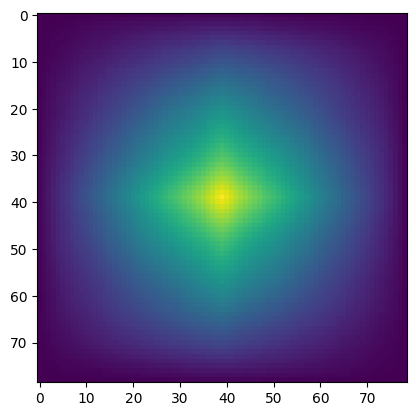

In [4]:
corr_hom=correlate2d(phi_hom,phi_hom)
corr_opt= correlate2d(phi_opt,phi_opt)
#compute and normalize correlation function
corr_hom/=np.prod(corr_hom.shape)
corr_opt/=np.prod(corr_opt.shape)
plt.imshow(corr_hom)


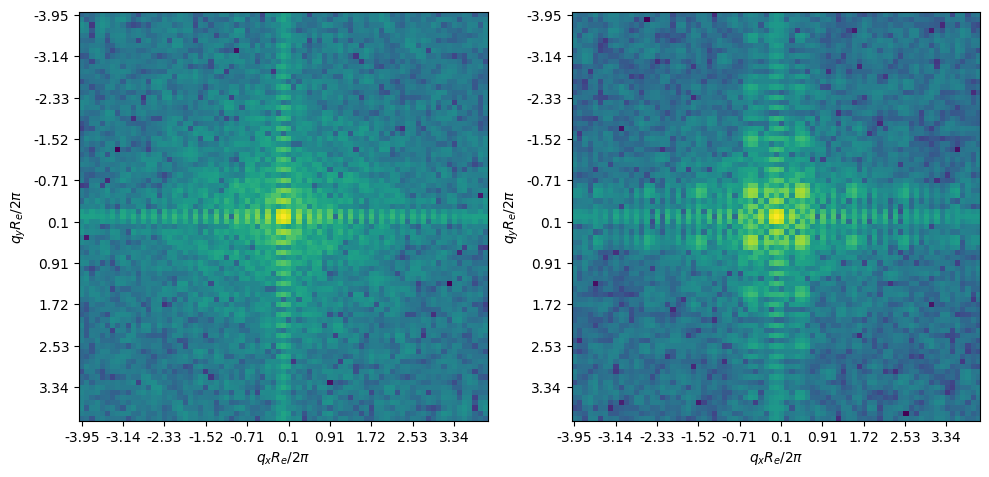

In [12]:
fourier_opt = np.fft.fftshift(fftn(rho0*corr_opt))
fourier_hom = np.fft.fftshift(fftn(rho0*corr_hom))

S_opt=np.abs(fourier_opt)**2
S_hom=np.abs(fourier_hom)**2

magnitude_spectrum_opt =np.log10(S_opt)
magnitude_spectrum_hom =np.log10(S_hom)

#magnitude_spectrum=S
# Get the image dimensions
height, width = magnitude_spectrum_opt.shape

# Set the frequency values for x and y axes
freq_x = np.fft.fftshift(np.fft.fftfreq(width))*8
freq_y = np.fft.fftshift(np.fft.fftfreq(height))*8




# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot data on the first subplot
for i in range(len(axs)):
    axs[i].set_xticks(np.arange(0, width, 8), labels=np.round(freq_x[::8], decimals=2))
    axs[i].set_yticks(np.arange(0, width, 8), labels=np.round(freq_x[::8], decimals=2))
    axs[i].set_xlabel(r'$q_xR_e/2\pi$')
    axs[i].set_ylabel(r'$q_yR_e/2\pi$')
#axs[1].set_colorbar()
axs[0].imshow(magnitude_spectrum_hom)
axs[1].imshow(magnitude_spectrum_opt)


# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()

In [6]:
##alternatively, get structure factor from beads directly
with h5py.File('coord_t1.h5', 'r') as f:
    beads=np.array(f['beads'])
    polytypes=np.array(f['poly_type'])
bead_types=np.repeat(polytypes,N)
print(bead_types.shape)


def structure_factor(qx,qz):
    S=0
    for i in range(len(beads)):
        if bead_types[i]==0:
            S+=np.exp(1j*(qx*beads[i,0]+qz*beads[i,2]))
        else:
            S-=np.exp(1j*(qx*beads[i,0]+qz*beads[i,2]))
    return S/len(beads)



q=np.linspace(-4,4,101)
print(q)
qx,qz=np.meshgrid(q,q)
S=structure_factor(2*np.pi*qx,2*np.pi*qz)


(80000,)
[-4.   -3.92 -3.84 -3.76 -3.68 -3.6  -3.52 -3.44 -3.36 -3.28 -3.2  -3.12
 -3.04 -2.96 -2.88 -2.8  -2.72 -2.64 -2.56 -2.48 -2.4  -2.32 -2.24 -2.16
 -2.08 -2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2
 -1.12 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24
 -0.16 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72
  0.8   0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68
  1.76  1.84  1.92  2.    2.08  2.16  2.24  2.32  2.4   2.48  2.56  2.64
  2.72  2.8   2.88  2.96  3.04  3.12  3.2   3.28  3.36  3.44  3.52  3.6
  3.68  3.76  3.84  3.92  4.  ]


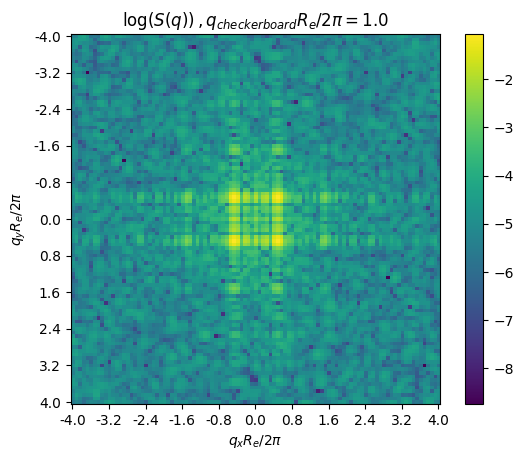

In [13]:
# Plot the magnitude spectrum
height, width = S.shape

plt.imshow(np.log10(np.abs(S)**2))
plt.colorbar()
plt.title(r'$\log(S( q))\,,$'+'$q_{checkerboard}R_e/2\pi=1.0$')
plt.xlabel(r'$q_xR_e/2\pi$')
plt.ylabel(r'$q_yR_e/2\pi$')

# Set the x and y tick labels
plt.xticks(np.arange(0, width, 10), labels=np.round(q[::10], decimals=2))
plt.yticks(np.arange(0, height, 10), labels=np.round(q[::10], decimals=2))
plt.show()